## Customer Shopping Behaviour — Exploratory Data Analysis (EDA)

This notebook explores to understand:

- Who the customers are (age, gender, location)
- What they buy (items, categories, sizes, colors, seasons)
- How they spend (purchase amount, payment method)
- What influences spend (discounts, subscriptions, shopping frequency)



In [1]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

try:
    import seaborn as sns
except ImportError as e:
    raise ImportError(
        "Seaborn is required for this notebook. Install it (e.g., `pip install seaborn`) and re-run."
    ) from e

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

DATA_PATH = "/kaggle/input/customer-shopping-behaviour-analysis/shopping_behavior_updated (1).csv"


In [2]:
df = pd.read_csv(DATA_PATH)

display(df.head())
print("shape:", df.shape)


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Discount Applied,Previous Purchases,Payment Method,Frequency of Purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Yes,31,PayPal,Annually


shape: (3900, 16)


In [3]:
# --- Data quality & schema ---

# Column names (keep originals for readability, but also create safe names if needed)
print("Columns:")
for c in df.columns:
    print("-", c)

print("\nDtypes:")
display(df.dtypes.to_frame("dtype"))

print("\nMissing values per column:")
display(df.isna().sum().to_frame("missing").sort_values("missing", ascending=False))

print("\nDuplicate rows:", int(df.duplicated().sum()))
print("Duplicate Customer IDs:", int(df["Customer ID"].duplicated().sum()))

# Basic numeric summary
num_cols = [
    "Age",
    "Purchase Amount (USD)",
    "Review Rating",
    "Previous Purchases",
]
display(df[num_cols].describe().T)


Columns:
- Customer ID
- Age
- Gender
- Item Purchased
- Category
- Purchase Amount (USD)
- Location
- Size
- Color
- Season
- Review Rating
- Subscription Status
- Discount Applied
- Previous Purchases
- Payment Method
- Frequency of Purchases

Dtypes:


,dtype
Customer ID,int64
Age,int64
Gender,object
Item Purchased,object
Category,object
Purchase Amount (USD),int64
Location,object
Size,object
Color,object
Season,object



Missing values per column:


,missing
Customer ID,0
Age,0
Gender,0
Item Purchased,0
Category,0
Purchase Amount (USD),0
Location,0
Size,0
Color,0
Season,0



Duplicate rows: 0
Duplicate Customer IDs: 0


,count,mean,std,min,25%,50%,75%,max
Age,3900.0,44.068462,15.207589,18.0,31.0,44.0,57.0,70.0
Purchase Amount (USD),3900.0,59.764359,23.685392,20.0,39.0,60.0,81.0,100.0
Review Rating,3900.0,3.749949,0.716223,2.5,3.1,3.7,4.4,5.0
Previous Purchases,3900.0,25.351538,14.447125,1.0,13.0,25.0,38.0,50.0


## Data dictionary (columns)

- **Customer ID**: unique customer identifier
- **Age**: customer age (years)
- **Gender**: customer gender
- **Item Purchased**: specific product type (e.g., Blouse, Shoes)
- **Category**: high-level product category (Clothing, Accessories, Footwear, Outerwear)
- **Purchase Amount (USD)**: purchase amount in USD
- **Location**: US state
- **Size**: product size (S/M/L/XL)
- **Color**: product color
- **Season**: season of purchase (Spring/Summer/Fall/Winter)
- **Review Rating**: customer rating (2.5–5.0)
- **Subscription Status**: whether customer has a subscription
- **Discount Applied**: whether a discount was applied
- **Previous Purchases**: historical purchase count
- **Payment Method**: payment method used
- **Frequency of Purchases**: how often the customer purchases

---


In [4]:
# --- Light feature engineering (for better analysis) ---

# Age bands (common retail segmentation bins)
age_bins = [18, 25, 35, 45, 55, 65, 71]
age_labels = ["18–24", "25–34", "35–44", "45–54", "55–64", "65–70"]
df["Age Group"] = pd.cut(df["Age"], bins=age_bins, labels=age_labels, right=False)

# Normalize purchase frequency into an approximate annual purchase rate
freq_to_per_year = {
    "Weekly": 52,
    "Bi-Weekly": 26,
    "Fortnightly": 26,
    "Monthly": 12,
    "Quarterly": 4,
    "Every 3 Months": 4,
    "Annually": 1,
}
df["Purchases/Year (Approx)"] = df["Frequency of Purchases"].map(freq_to_per_year)

# Set categorical ordering (useful for plots)
season_order = ["Spring", "Summer", "Fall", "Winter"]
frequency_order = ["Weekly", "Bi-Weekly", "Fortnightly", "Monthly", "Every 3 Months", "Quarterly", "Annually"]

df["Season"] = pd.Categorical(df["Season"], categories=season_order, ordered=True)
df["Frequency of Purchases"] = pd.Categorical(df["Frequency of Purchases"], categories=frequency_order, ordered=True)

display(df[["Age", "Age Group", "Frequency of Purchases", "Purchases/Year (Approx)"]].head())


,Age,Age Group,Frequency of Purchases,Purchases/Year (Approx)
0,55,55–64,Fortnightly,26
1,19,18–24,Fortnightly,26
2,50,45–54,Weekly,52
3,21,18–24,Weekly,52
4,45,45–54,Annually,1


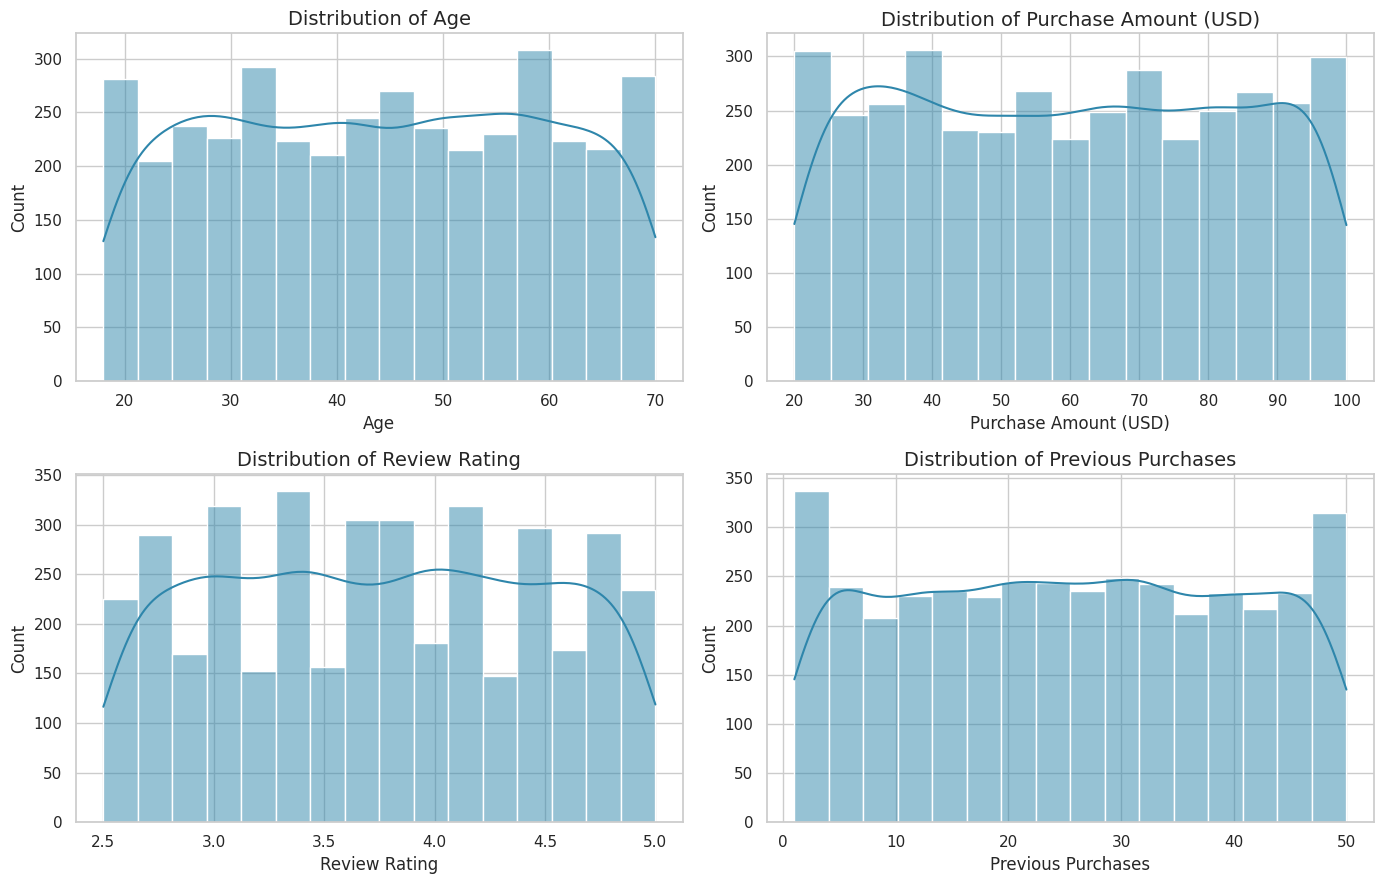

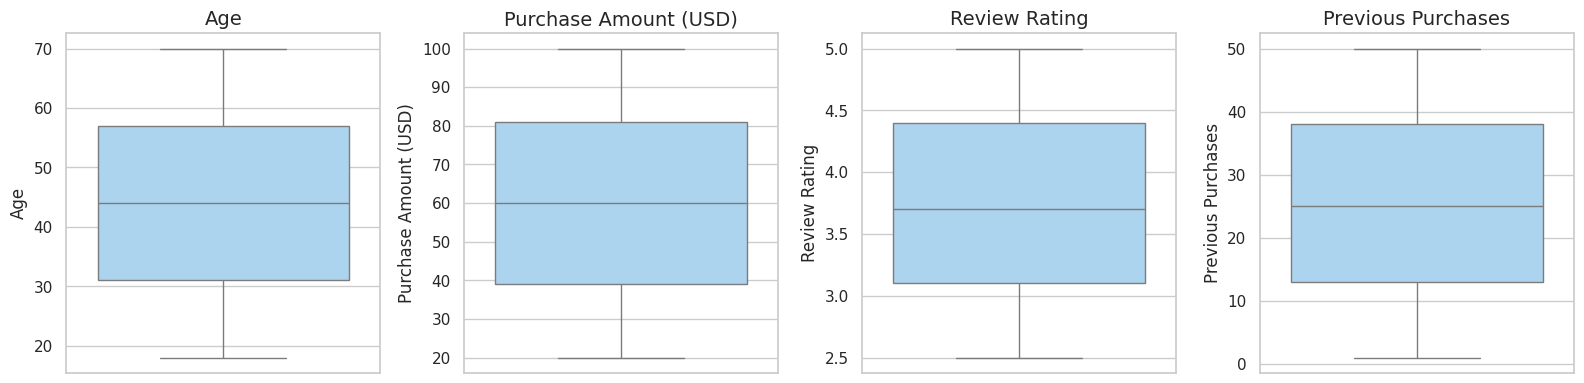

In [5]:
## Univariate analysis — numeric features

num_cols = ["Age", "Purchase Amount (USD)", "Review Rating", "Previous Purchases"]

fig, axes = plt.subplots(2, 2, figsize=(14, 9))
axes = axes.flatten()

for ax, col in zip(axes, num_cols):
    sns.histplot(df[col], kde=True, ax=ax, color="#2E86AB")
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

# Boxplots (quick outlier / spread check)
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, col in zip(axes, num_cols):
    sns.boxplot(y=df[col], ax=ax, color="#A2D6F9")
    ax.set_title(col)
plt.tight_layout()
plt.show()


/tmp/ipykernel_17/1682770862.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=order, ax=ax, palette="viridis")
/tmp/ipykernel_17/1682770862.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=order, ax=ax, palette="viridis")
/tmp/ipykernel_17/1682770862.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x=col, order=order, ax=ax, palette="viridis")
/tmp/ipykernel_17/1682770862.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed i

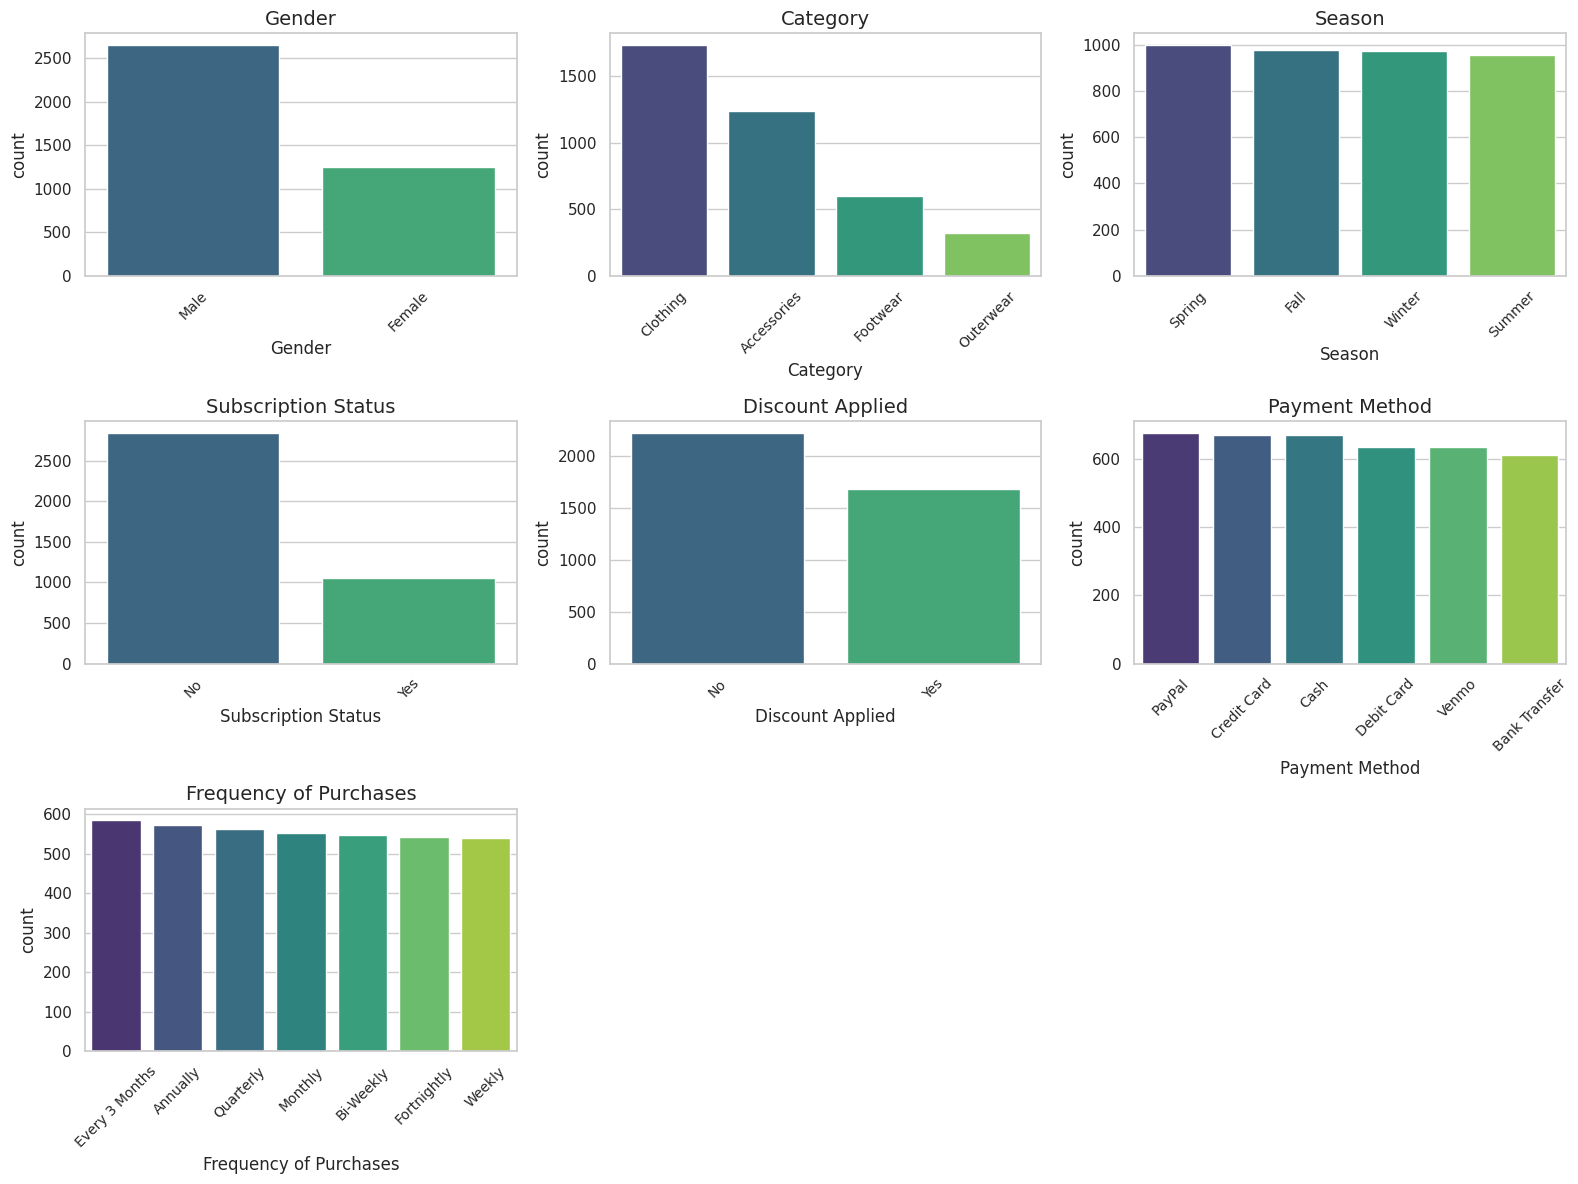

In [6]:
## Univariate analysis — key categorical features

cat_cols = [
    "Gender",
    "Category",
    "Season",
    "Subscription Status",
    "Discount Applied",
    "Payment Method",
    "Frequency of Purchases",
]

fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, order=order, ax=ax, palette="viridis")
    ax.set_title(col)
    ax.tick_params(axis="x", rotation=45, labelsize=10)

# Hide unused subplots
for j in range(len(cat_cols), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


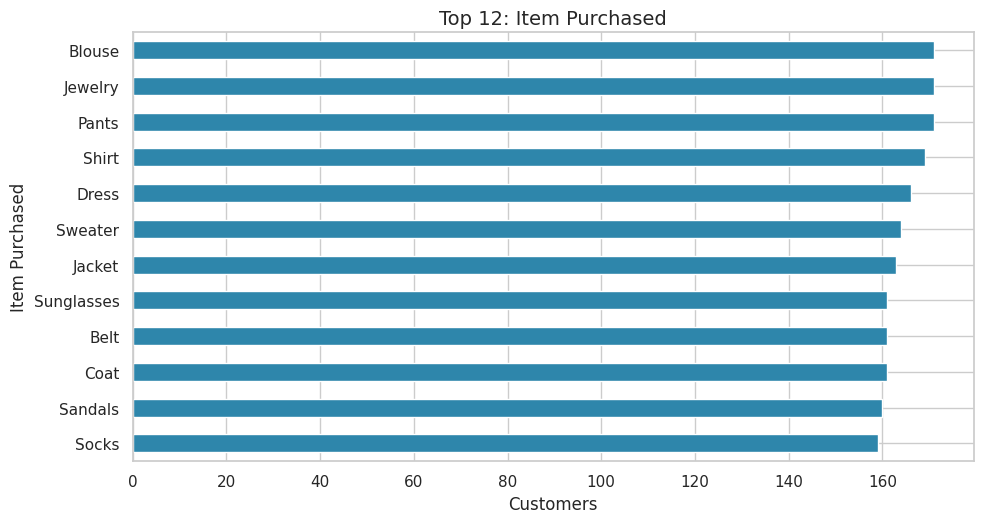

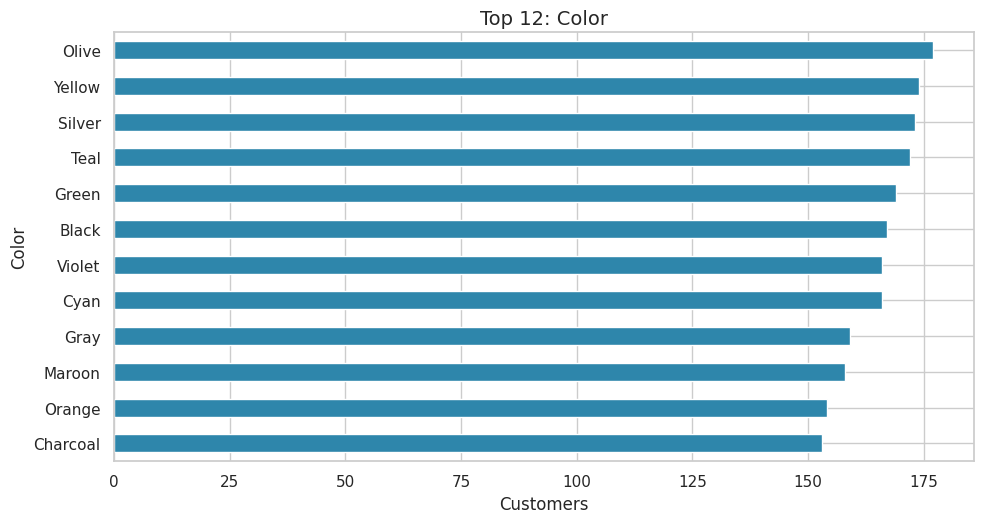

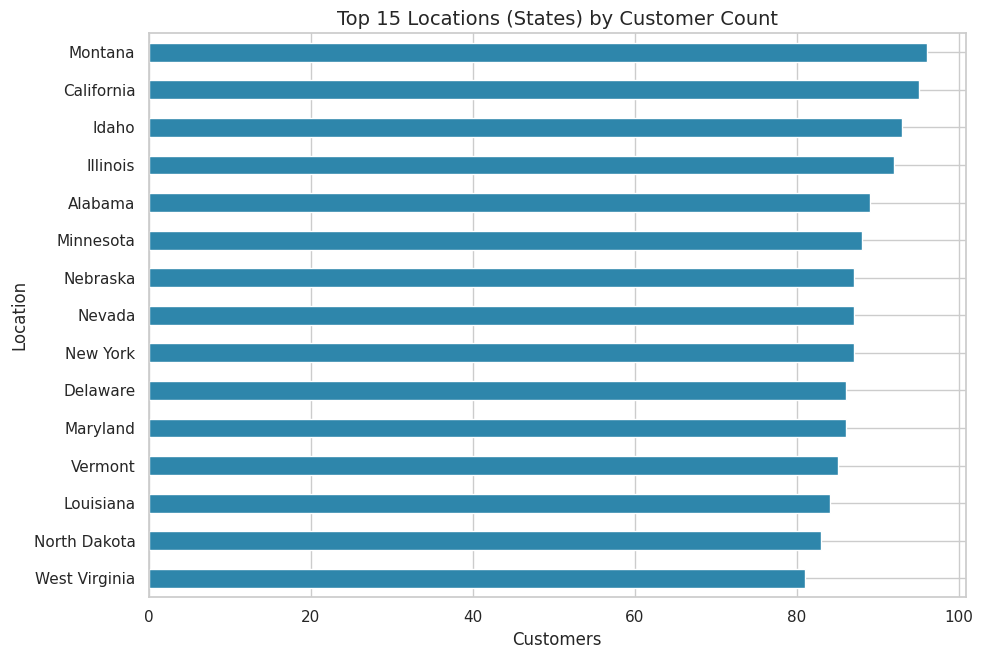

In [7]:
## Product & preference popularity (Top-N)

def plot_top_n(col, n=10, title=None):
    vc = df[col].value_counts().head(n).sort_values()
    plt.figure(figsize=(10, max(4, n * 0.45)))
    vc.plot(kind="barh", color="#2E86AB")
    plt.title(title or f"Top {n}: {col}")
    plt.xlabel("Customers")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

plot_top_n("Item Purchased", n=12)
plot_top_n("Color", n=12)
plot_top_n("Location", n=15, title="Top 15 Locations (States) by Customer Count")


/tmp/ipykernel_17/2466026788.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, ax=ax, showfliers=False, palette="Set2")
/tmp/ipykernel_17/2466026788.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, ax=ax, showfliers=False, palette="Set2")
/tmp/ipykernel_17/2466026788.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=x, y=y, order=order, ax=ax, showfliers=False, palette="Set2")
/tmp/ipykernel_17/2466026788.py:20: FutureWarning: 

Passing `palette` without ass

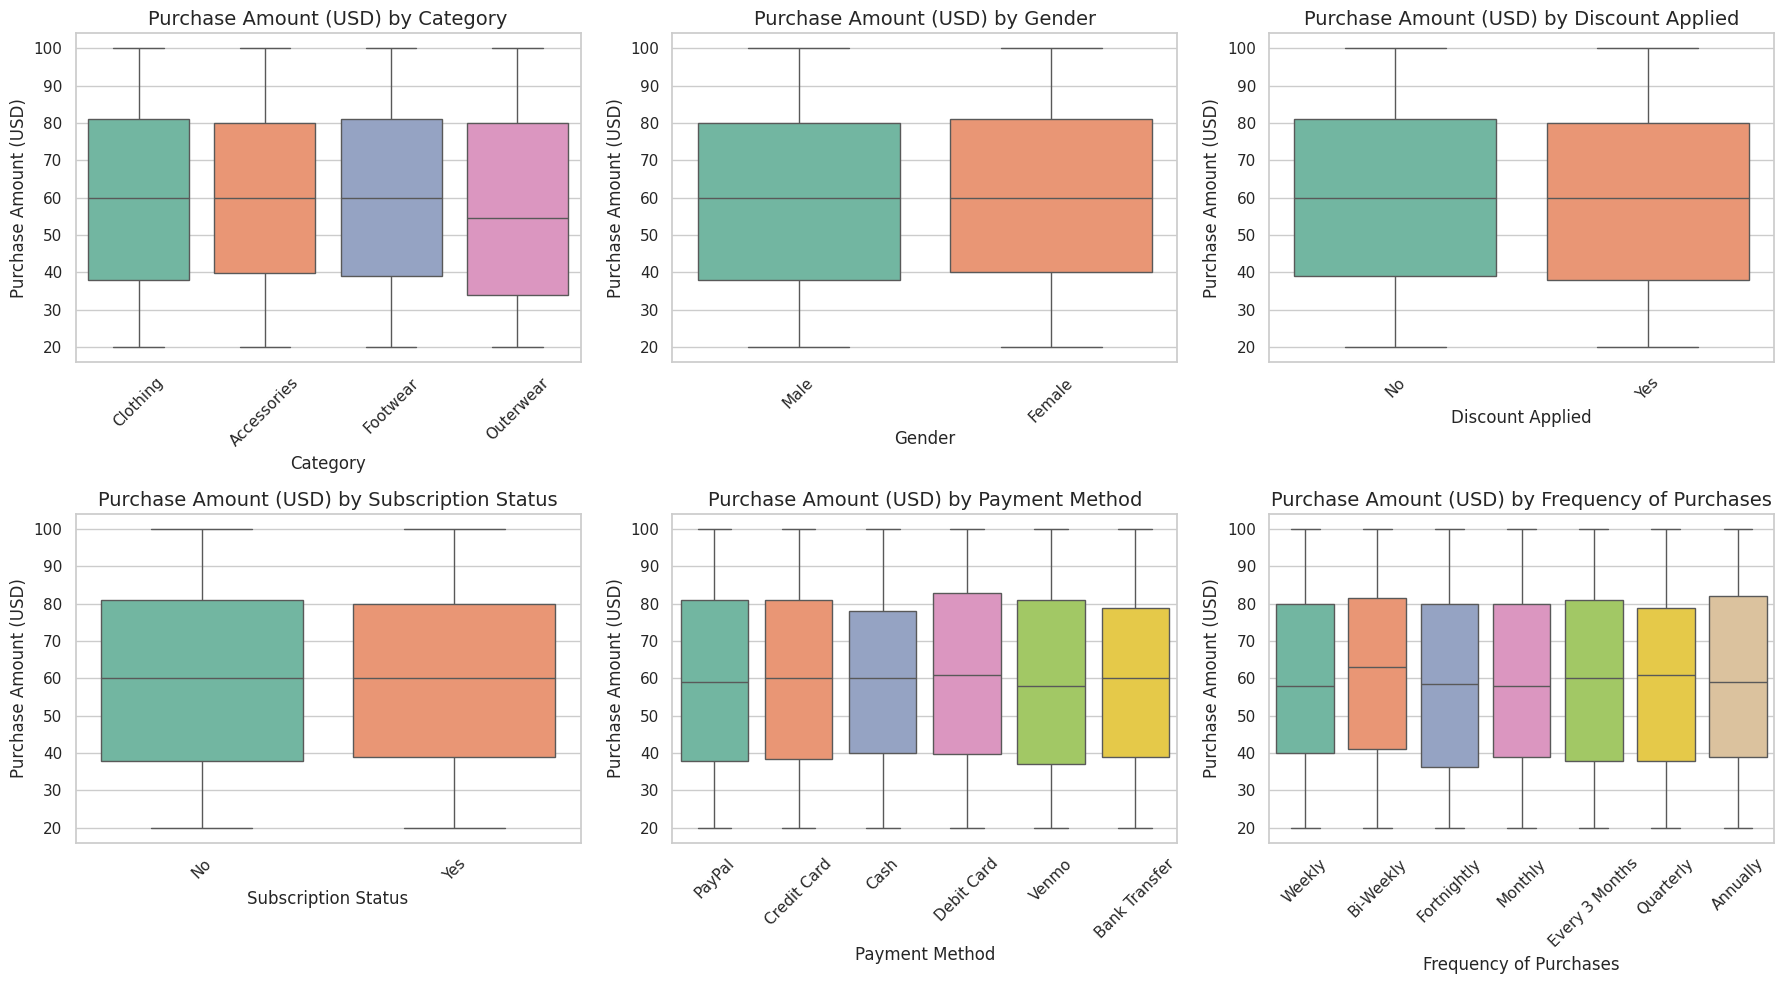

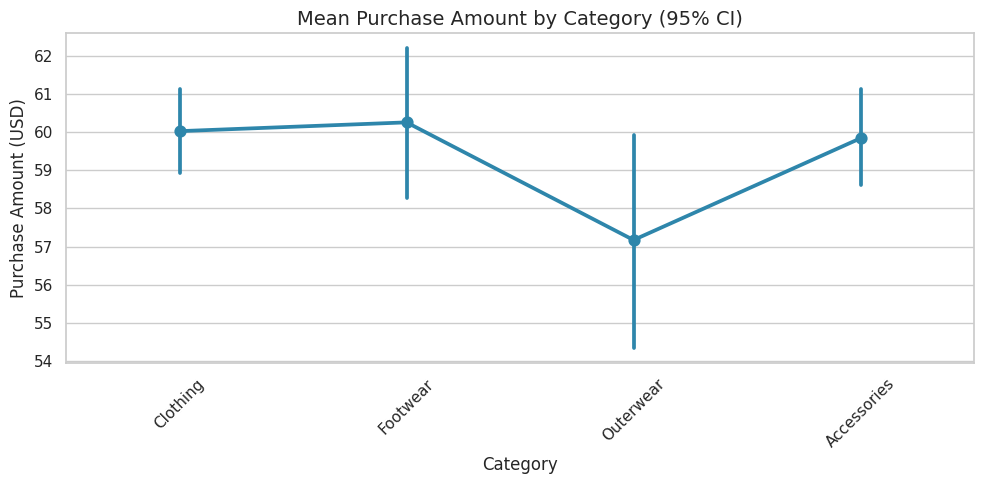

In [8]:
## Bivariate analysis — what drives purchase amount?

y = "Purchase Amount (USD)"

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

plots = [
    ("Category", None),
    ("Gender", None),
    ("Discount Applied", ["No", "Yes"]),
    ("Subscription Status", ["No", "Yes"]),
    ("Payment Method", None),
    ("Frequency of Purchases", list(df["Frequency of Purchases"].cat.categories)),
]

for ax, (x, order) in zip(axes, plots):
    if order is None:
        order = df[x].value_counts().index
    sns.boxplot(data=df, x=x, y=y, order=order, ax=ax, showfliers=False, palette="Set2")
    ax.set_title(f"{y} by {x}")
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

# Mean purchase amount (with 95% CI) for quick comparison
plt.figure(figsize=(10, 5))
sns.pointplot(data=df, x="Category", y=y, errorbar=("ci", 95), color="#2E86AB")
plt.title("Mean Purchase Amount by Category (95% CI)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


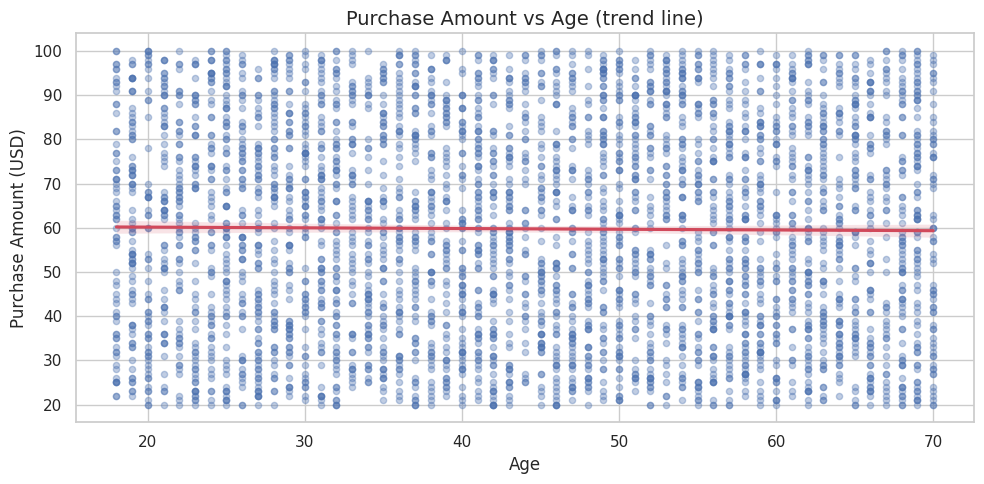

/tmp/ipykernel_17/258389866.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Age Group", y="Purchase Amount (USD)", showfliers=False, palette="Blues")


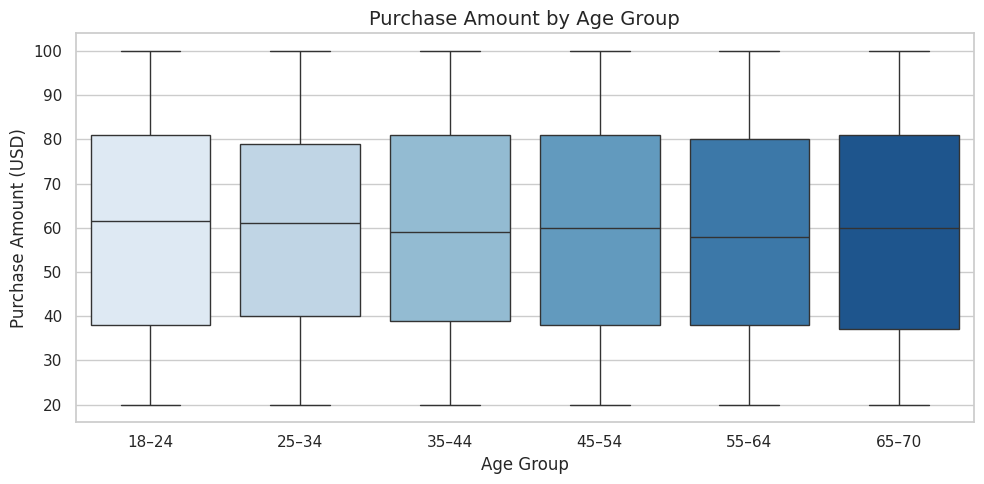

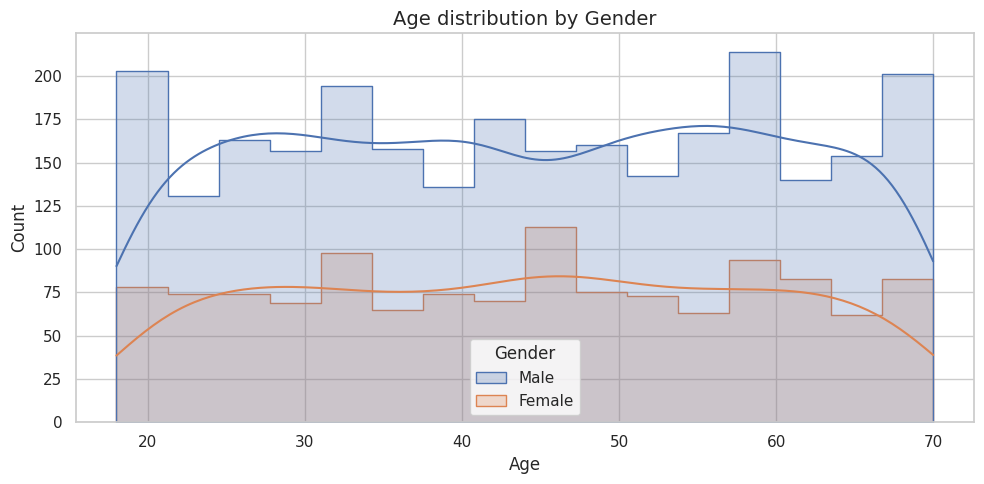

In [9]:
## Age insights

# Spend vs age (scatter + trend)
plt.figure(figsize=(10, 5))
sns.regplot(data=df, x="Age", y="Purchase Amount (USD)", scatter_kws={"alpha": 0.35, "s": 20}, line_kws={"color": "#D1495B"})
plt.title("Purchase Amount vs Age (trend line)")
plt.tight_layout()
plt.show()

# Spend by age group
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x="Age Group", y="Purchase Amount (USD)", showfliers=False, palette="Blues")
plt.title("Purchase Amount by Age Group")
plt.tight_layout()
plt.show()

# Age distribution by gender
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="Age", hue="Gender", kde=True, element="step")
plt.title("Age distribution by Gender")
plt.tight_layout()
plt.show()


,count,mean,median,mean_diff_vs_no,median_diff_vs_no
Discount Applied,,,,,
No,2223,60.130454,60.0,0.000000,0.0
Yes,1677,59.279070,60.0,-0.851385,0.0


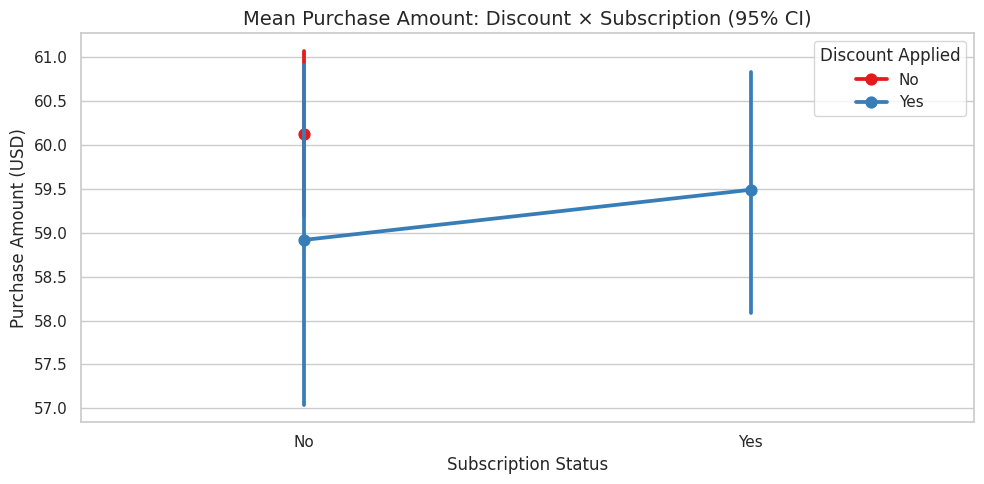

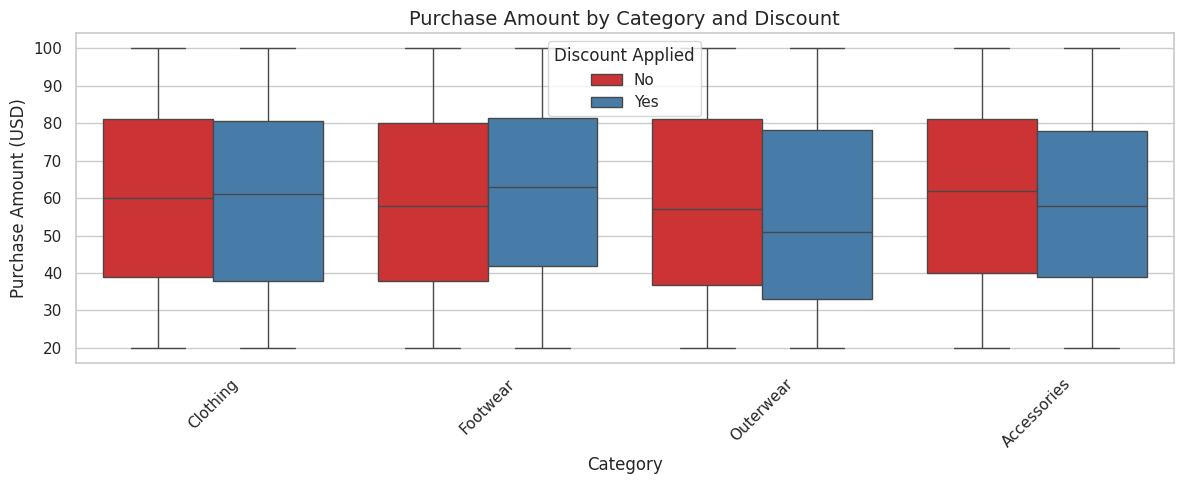

In [10]:
## Discount & subscription impact

y = "Purchase Amount (USD)"

# Overall difference
summary = (
    df.groupby("Discount Applied")[y]
    .agg(["count", "mean", "median"])
    .sort_index()
)
summary["mean_diff_vs_no"] = summary["mean"] - summary.loc["No", "mean"]
summary["median_diff_vs_no"] = summary["median"] - summary.loc["No", "median"]

display(summary)

# Interaction: discount x subscription
plt.figure(figsize=(10, 5))
sns.pointplot(
    data=df,
    x="Subscription Status",
    y=y,
    hue="Discount Applied",
    order=["No", "Yes"],
    hue_order=["No", "Yes"],
    errorbar=("ci", 95),
    palette="Set1",
)
plt.title("Mean Purchase Amount: Discount × Subscription (95% CI)")
plt.tight_layout()
plt.show()

# Does discount impact differ by category?
plt.figure(figsize=(12, 5))
sns.boxplot(
    data=df,
    x="Category",
    y=y,
    hue="Discount Applied",
    hue_order=["No", "Yes"],
    showfliers=False,
    palette="Set1",
)
plt.title("Purchase Amount by Category and Discount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


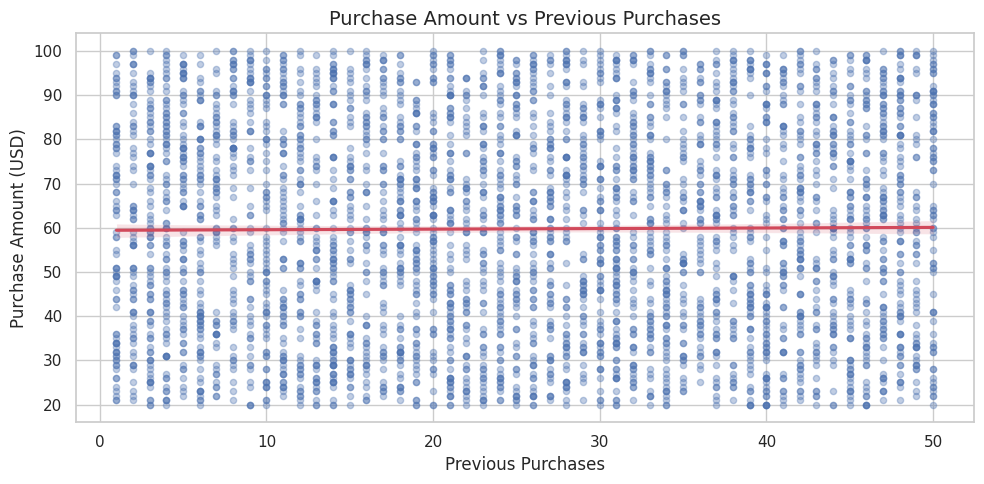

/tmp/ipykernel_17/2945964572.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


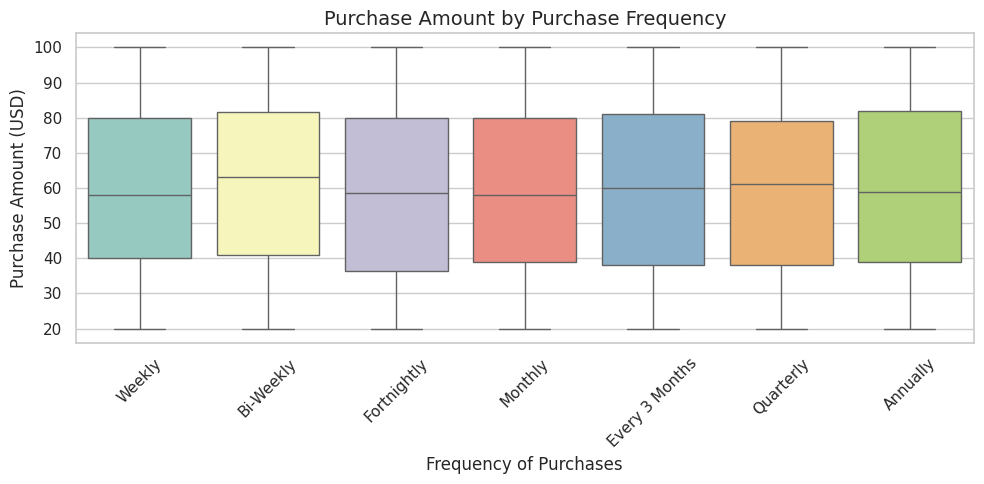

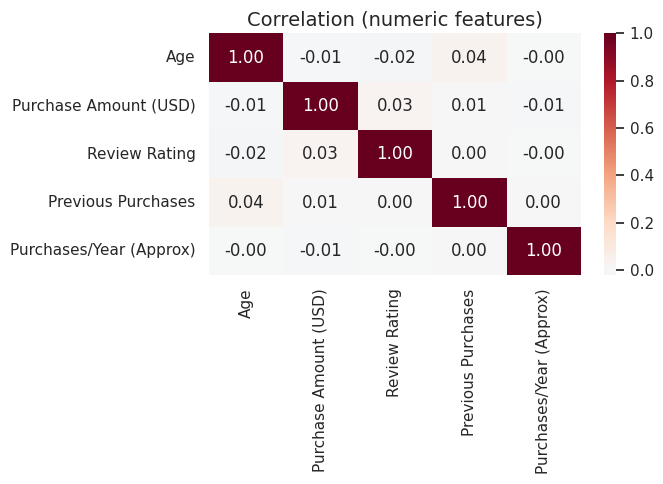

In [11]:
## Loyalty / engagement signals

# Previous purchases vs spend
plt.figure(figsize=(10, 5))
sns.regplot(
    data=df,
    x="Previous Purchases",
    y="Purchase Amount (USD)",
    scatter_kws={"alpha": 0.35, "s": 20},
    line_kws={"color": "#D1495B"},
)
plt.title("Purchase Amount vs Previous Purchases")
plt.tight_layout()
plt.show()

# Approx annual purchase rate vs spend
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df,
    x="Frequency of Purchases",
    y="Purchase Amount (USD)",
    order=list(df["Frequency of Purchases"].cat.categories),
    showfliers=False,
    palette="Set3",
)
plt.title("Purchase Amount by Purchase Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation heatmap (numeric-only)
num_for_corr = ["Age", "Purchase Amount (USD)", "Review Rating", "Previous Purchases", "Purchases/Year (Approx)"]
corr = df[num_for_corr].corr(numeric_only=True)

plt.figure(figsize=(7, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
plt.title("Correlation (numeric features)")
plt.tight_layout()
plt.show()


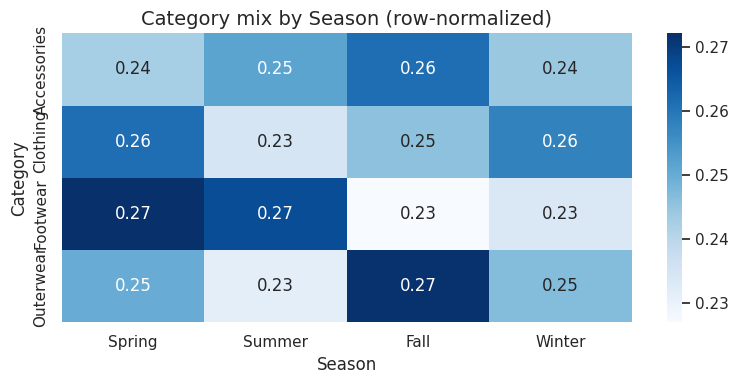

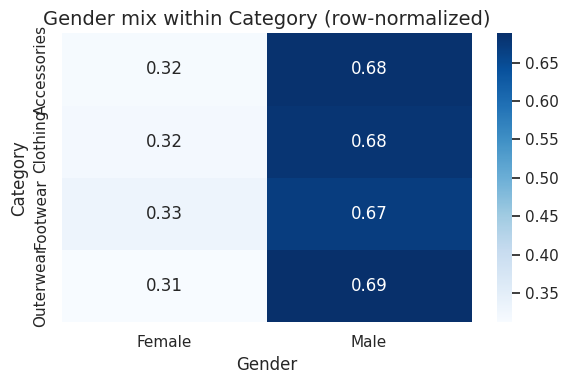

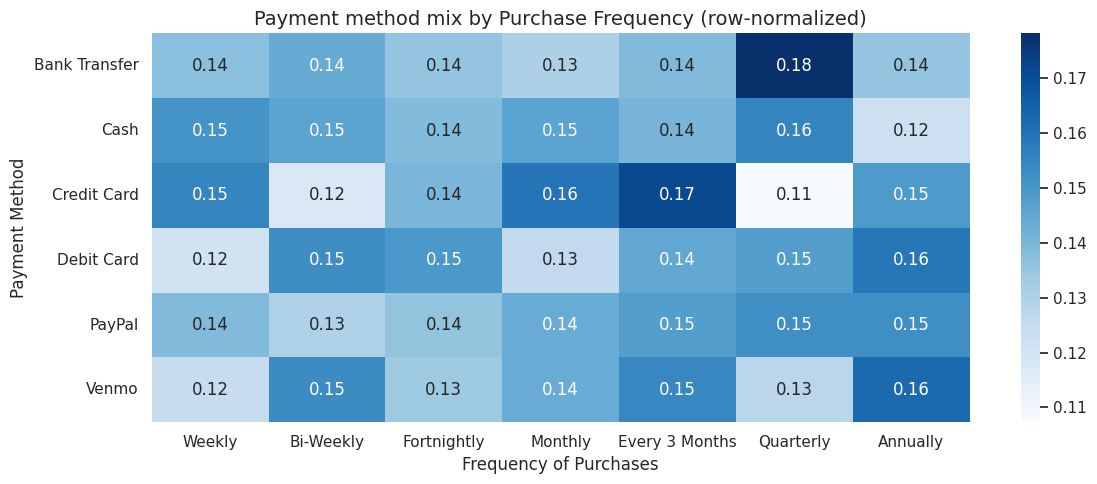

Frequency of Purchases,Weekly,Bi-Weekly,Fortnightly,Monthly,Every 3 Months,Quarterly,Annually
Payment Method,,,,,,,
Bank Transfer,0.137255,0.143791,0.135621,0.130719,0.138889,0.178105,0.135621
Cash,0.150746,0.146269,0.138806,0.146269,0.140299,0.155224,0.122388
Credit Card,0.154993,0.117735,0.140089,0.159463,0.171386,0.107303,0.149031
Debit Card,0.121069,0.152516,0.149371,0.125786,0.144654,0.147799,0.158805
PayPal,0.138848,0.129985,0.135894,0.143279,0.147710,0.152142,0.152142
Venmo,0.124606,0.152997,0.134069,0.143533,0.154574,0.127760,0.162461


In [12]:
## Categorical relationships (cross-tabs)

def crosstab_heatmap(a, b, normalize=None, figsize=(10, 5), title=None):
    ct = pd.crosstab(df[a], df[b], normalize=normalize)
    plt.figure(figsize=figsize)
    sns.heatmap(ct, cmap="Blues", annot=(ct.size <= 60), fmt=".2f" if normalize else "d")
    plt.title(title or f"{a} vs {b}" + (" (normalized)" if normalize else ""))
    plt.ylabel(a)
    plt.xlabel(b)
    plt.tight_layout()
    plt.show()
    return ct

# Share of categories by season
crosstab_heatmap("Category", "Season", normalize="index", figsize=(8, 4), title="Category mix by Season (row-normalized)")

# Gender mix by category
crosstab_heatmap("Category", "Gender", normalize="index", figsize=(6, 4), title="Gender mix within Category (row-normalized)")

# Payment method vs frequency
crosstab_heatmap("Payment Method", "Frequency of Purchases", normalize="index", figsize=(12, 5), title="Payment method mix by Purchase Frequency (row-normalized)")
